<a href="https://colab.research.google.com/github/DavoodSZ1993/Dive_into_Deep_Learning/blob/main/10_2_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l==1.0.0-alpha1.post0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 KB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.0 MB/s eta 0:00:00


## 10.2 Gated Recurrent Units (GRU)

### 10.2.4 Implementation from Scratch

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

#### Initializing Model Parameters

In [3]:
class GRUScratch(d2l.Module):
  def __init__(self, num_inputs, num_hiddens, sigma=0.01):
    super().__init__()
    self.save_hyperparameters()

    init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
    triple = lambda: (init_weight(num_inputs, num_hiddens),
                      init_weight(num_hiddens, num_hiddens),
                      nn.Parameter(torch.zeros(num_hiddens)))
    self.W_xz, self.W_hz, self.b_z = triple() # Update gate
    self.W_xr, self.W_hr, self.b_r = triple() # Reset gate
    self.W_xh, self.W_hh, self.b_h = triple() # Candidate hidden state

#### Defining the Model

In [4]:
@d2l.add_to_class(GRUScratch)
def forward(self, inputs, H=None):
  if H is None:
    # Initial state with shape: (batch_size, num_hiddens)
    H = torch.zeros((inputs.shape[1], self.num_hiddens), device=inputs.device)

  outputs = []
  for X in inputs: 
    Z = torch.sigmoid(torch.matmul(X, self.W_xz) +
                      torch.matmul(H, self.W_hz) + self.b_z)
    R = torch.sigmoid(torch.matmul(X, self.W_xr) +
                  torch.matmul(H, self.W_hr) + self.b_r)
    H_tilde = torch.sigmoid(torch.matmul(X, self.W_xh) +
                  torch.matmul(R * H, self.W_hh) + self.b_h)
    H = Z * H + (1 - Z) * H_tilde
    outputs.append(H)
  return outputs, H

#### Training

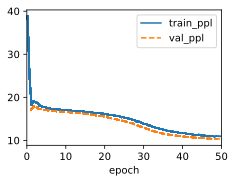

In [5]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
gru = GRUScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(gru, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

### 10.2.5 Concise Implementation

In [6]:
class GRU(d2l.RNN):
  def __init__(self, num_inputs, num_hiddens):
    d2l.Module.__init__(self)
    self.save_hyperparameters()
    self.rnn = nn.GRU(num_inputs, num_hiddens)

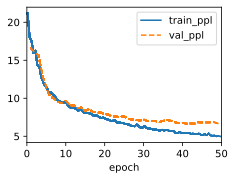

In [7]:
gru = GRU(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)

In [9]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has on the psome the ti'